# one element digital image correlation

- Affine deformation (not a Bilinear Quadrilateral (Q4), (Todo add the x*y)
- use non-linear Least Square from Scipy (Levenberg–Marquardt algorithm)
- use RectBivariateSpline for interpolation and gradient evaluation (from Scipy)

In [6]:
import numpy as np
import matplotlib.pylab as plt
from glob import glob
import os
from skimage import io

In [192]:
from skimage.transform import pyramid_reduce
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import least_squares
from scipy.ndimage import gaussian_filter

In [10]:
def get_number(string):
    '''Extract all digits from given string'''
    return int(''.join(filter(str.isdigit, string)))

def load_from_dir(path, fileext='.tif'):
    image_pattern = os.path.join(path, '*'+fileext)
    image_list = sorted(glob(image_pattern),
                        key=get_number)
    
    print(len(image_list), 'images found:')
    print(', '.join(image_list[:2]) + '...,  ' +  image_list[-1])
    return [io.imread(filename) for filename in image_list]

In [205]:
def flatten_and_norm(I):
    """Remove thrid order polynomial from image"""
    xi_span = np.arange(I.shape[1], dtype=np.float64)
    yi_span = np.arange(I.shape[0], dtype=np.float64)

    xi_grid, yi_grid = np.meshgrid(xi_span, yi_span)
    xi_grid_flatten, yi_grid_flatten = xi_grid.flatten(), yi_grid.flatten()
    I_flatten = I.flatten()

    M = np.vstack([np.ones_like(xi_grid_flatten),
                   yi_grid_flatten, xi_grid_flatten,
                   xi_grid_flatten**2, yi_grid_flatten**2,
                   xi_grid_flatten*yi_grid_flatten,
                   xi_grid_flatten**3, yi_grid_flatten**3]).T

    coeffs, residuals, _, _ = np.linalg.lstsq(M, I_flatten, rcond=None)

    background = np.matmul(M, coeffs).reshape(I.shape)
    I = I - background
    return I/I.std()

def smooth_and_norm(I):
    background = gaussian_filter(I, 200)
    I = I - background
    return I/I.std()

In [206]:
# load the images
path = "./images/"
images = load_from_dir(path, fileext='.png')
images = [I.mean(axis=2) if I.ndim==3 else I for I in images] # convert to grayscale if needed

images = [smooth_and_norm(I)for I in images]

16 images found:
./images/Top_snap0 .png, ./images/Top_snap1 .png...,  ./images/Top_snap15 .png


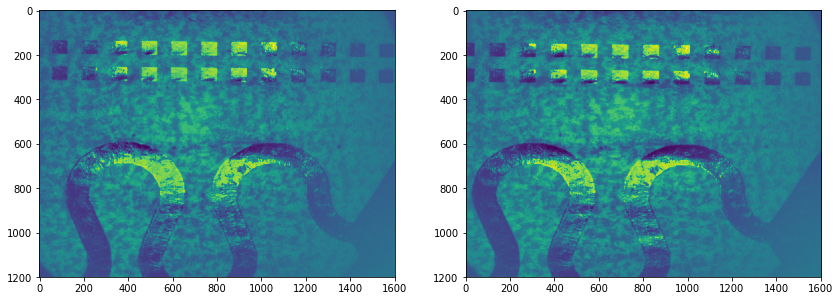

In [209]:
# Select the two images
I, J = images[1], images[2]

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.imshow(I, cmap='viridis');
ax2.imshow(J, cmap='viridis');

In [287]:
# Affine transform
def affine_transform(x, y, p):
    u, v = p[0], p[1]
    e11, e12, e21, e22 = p[2:]
    x_def = u + e11*x + e12*y
    y_def = v + e21*x + e22*y
    return x_def, y_def

# Gradient
def transf_grad(x, y, p):
    one = np.ones_like(x)
    zero = np.zeros_like(x)
    Tx_dp = np.vstack([one, zero, x, y, zero, zero]).T
    Ty_dp = np.vstack([zero, one, zero, zero, x, y]).T
    return Tx_dp, Ty_dp

# Residuals:
def delta_xi(p, xi, yi, Ispline, Jspline):
    u, v = affine_transform(xi, yi, p)
    I, J = Ispline(xi, yi, grid=False), Jspline(u, v, grid=False)
    #I = (I-I.mean())/I.std()
    #J = (J-J.mean())/J.std()
    #return I - J
    r = I - J
    return (r - r.mean())/r.std()

# Gradient of the residuals
def grad_xi(p, xi, yi, Ispline, Jspline):
    u, v = affine_transform(xi, yi, p)
    Tx, Ty = transf_grad(xi, yi, p)
    jac_x = -Tx*Jspline(u, v, dx=1, grid=False)[:, np.newaxis]
    jac_y = -Ty*Jspline(u, v, dy=1, grid=False)[:, np.newaxis]
    return jac_x + jac_y

In [288]:
def solve(I, J, box, downscale_factor, p_zero=[0, 0, 1, 0, 0, 1]):
    # Down sample the images
    if downscale_factor > 1:
        I_coarse = pyramid_reduce(I, downscale_factor)
        J_coarse = pyramid_reduce(J, downscale_factor)
    else:
        I_coarse = I
        J_coarse = J
        
    # Build spline interpolation
    xi = np.linspace(0, I.shape[0], I_coarse.shape[0])
    yi = np.linspace(0, I.shape[1], I_coarse.shape[1])

    Ispline = RectBivariateSpline(xi, yi, I_coarse)
    Jspline = RectBivariateSpline(xi, yi, J_coarse)

    # Place sample points
    x, y, w, h = box
    xi_span = np.linspace(x, x+w, w//downscale_factor)
    yi_span = np.linspace(y, y+h, h//downscale_factor)

    xi_grid, yi_grid = np.meshgrid(xi_span, yi_span)

    xi, yi = xi_grid.flatten(), yi_grid.flatten()
    
    # solve
    res = least_squares(delta_xi, p_zero,
                        jac=grad_xi,
                        args=(xi, yi, Ispline, Jspline))
    print(res.message)
    return res.x

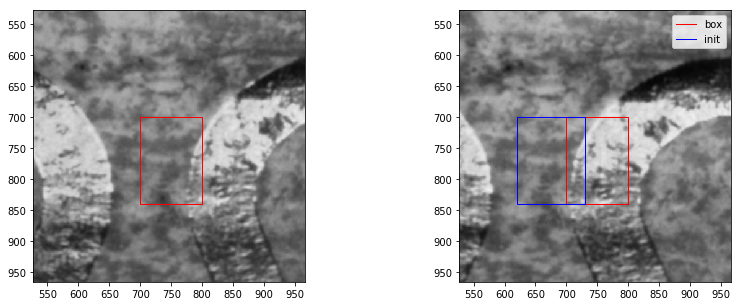

In [289]:
# Define the element
box = 700, 700, 100, 140  # x, y, w, h
x, y, w, h = box
box_polyline = np.array([[x, x+w, x+w, x, x],
                         [y, y, y+h, y+h, y]]).T

# Define the initial deformation
p_opti = [-150, 0, 1.1, 0, 0, 1]# [-150, 0, 1.1, 0, 0, 1]

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.imshow(I, cmap = 'gray');
ax2.imshow(J, cmap = 'gray');
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='blue');
#ax1.plot(xi, yi, '.', color='red');

xDef, yDef = affine_transform(box_polyline[:, 0], box_polyline[:, 1], p_opti)
#ax2.plot(xDef, yDef, '.', color='red')
ax2.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');
ax2.plot(xDef, yDef,
         '-', color='blue', linewidth=1, label='init');
plt.legend();

def get_lower_bound(a, b):
    return min(np.min(box_polyline), np.min(xDef))*0.85
def get_upper_bound(a, b):
    return max(np.max(box_polyline), np.max(xDef))*1.15

x_min = get_lower_bound(box_polyline[:, 0], xDef)
x_max = get_upper_bound(box_polyline[:, 0], xDef)
y_min = get_lower_bound(box_polyline[:, 1], yDef)
y_max = get_upper_bound(box_polyline[:, 1], yDef)

ax1.set_xlim(x_min, x_max);ax1.set_ylim(y_max, y_min);
ax2.set_xlim(x_min, x_max);ax2.set_ylim(y_max, y_min);

In [290]:
# Loop over scales
for k in range(0, 5)[::-1]:
    downfactor = 2**k
    p_opti = solve(I, J, box, downfactor, p_zero=p_opti)

`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.
`xtol` termination condition is satisfied.


In [291]:
print(p_opti)

[-2.57297236e+02 -1.07320663e+02  1.17269839e+00  6.42277758e-02
  1.18354264e-01  1.00785861e+00]


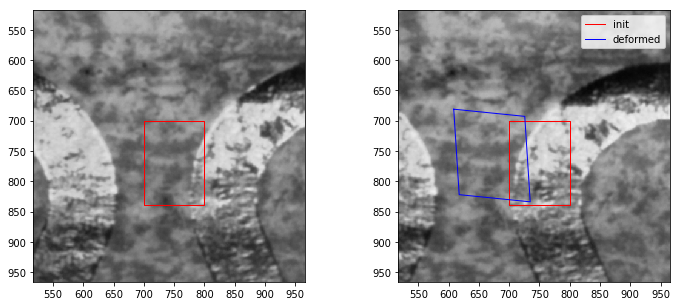

In [292]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(I, cmap = 'gray');
ax2.imshow(J, cmap = 'gray');
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='blue');
#ax1.plot(xi, yi, '.', color='red');

xDef, yDef = affine_transform(box_polyline[:, 0], box_polyline[:, 1], p_opti)
#ax2.plot(xDef, yDef, '.', color='red')
ax2.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='init');
ax2.plot(xDef, yDef,
         '-', color='blue', linewidth=1, label='deformed');
plt.legend();

def get_lower_bound(a, b):
    return min(np.min(box_polyline), np.min(xDef))*0.85
def get_upper_bound(a, b):
    return max(np.max(box_polyline), np.max(xDef))*1.15

x_min = get_lower_bound(box_polyline[:, 0], xDef)
x_max = get_upper_bound(box_polyline[:, 0], xDef)
y_min = get_lower_bound(box_polyline[:, 1], yDef)
y_max = get_upper_bound(box_polyline[:, 1], yDef)

ax1.set_xlim(x_min, x_max);ax1.set_ylim(y_max, y_min);
ax2.set_xlim(x_min, x_max);ax2.set_ylim(y_max, y_min);

In [ ]:
p_opti